In [84]:
from functools import partial
import os
import re

from datasets import load_from_disk
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
from parallel_pandas import ParallelPandas
import scipy.stats as stats
import seaborn as sns
from tqdm.notebook import tqdm

ParallelPandas.initialize(n_cpu=len(os.sched_getaffinity(0)) - 1, split_factor=5)

In [85]:
def load_data(path, split='train', model_map=None, filter_fn=None):
    ds = load_from_disk(path)[split]
    if 'model' not in ds.column_names:
        ds = ds.map(lambda x: {
            'model': 'human' if str(x['label']) == '0' else 'machine'
        }, num_proc=len(os.sched_getaffinity(0)))
    if model_map:
        ds = ds.map(lambda x: {'model': model_map.get(x['model'], x['model'])})
    if filter_fn:
        ds = ds.filter(filter_fn, num_proc=len(os.sched_getaffinity(0)))
    return ds.to_pandas()

In [86]:
def ngram_entropy(record, lengths, n=3):
    for l in lengths:
        if len(record['text']) < l:
            break
        text = record['text'][:l]
        _, counts = np.unique([text[i:i + n] for i in range(len(text) - n + 1)], return_counts=True)
        counts = counts.astype(np.float64) / np.sum(counts)
        record[l] = float(-np.sum(counts * np.log2(counts)))
    return record


_ws_regex = re.compile(r'\s+')

def unique_word_counts(record, lengths):
    for l in lengths:
        if len(record['text']) < l:
            break
        text = record['text'][:l]
        record[l] = len(np.unique(_ws_regex.split(text.strip()), return_counts=True)[1])
    return record


def calc_at_length_intervals(calc_fn, df, value_name, min_length=700, interval=100, max_length=None):
    lengths = list(range(min_length, max_length or df['text'].str.len().max(), interval))
    df = df[['id', 'model', 'text']]
    df = pd.concat([df, pd.DataFrame(columns=lengths, dtype=float)], ignore_index=False, axis=1)
    df = df.p_apply(lambda rec: calc_fn(rec, lengths), axis=1)
    return df.melt(id_vars=['id', 'model'], value_vars=df.columns[3:], var_name='length', value_name=value_name).set_index(['length', 'id'])

In [101]:
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Helvetica, sans-serif'
plt.rcParams['font.size'] = 8
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['grid.linewidth'] = .25


def get_model_hue_palette(df, human_first=True):
    sort_key_fn = None
    if human_first:
        sort_key_fn = lambda col: col.str.lower().replace('human', '___')
    df = df.sort_values(by='model', ascending=True, key=sort_key_fn)
    models = df['model'].unique()
    return dict(zip(models, sns.color_palette('husl', len(models))))


def plot_entropy_per_model(df, outlier_checkpoint=1000, min_samples=30, xlim=None, ylim=None,
                           errorbar=('ci', 95), ngram_order=None, plot_baseline=False, savefig=None):
    hue_palette = get_model_hue_palette(df)

    # Filter model outliers
    df_cp = df.loc[outlier_checkpoint]
    iqr_pctl = df_cp.reset_index()[['model', 'entropy']]
    iqr_pctl = iqr_pctl.groupby('model').quantile([.25, .75]).unstack()
    iqr = iqr_pctl[iqr_pctl.columns[1]] - iqr_pctl[iqr_pctl.columns[0]]
    df = df.reset_index().set_index('id')
    for i in iqr_pctl.index:
        df_tmp = df_cp[df_cp['model'] == i]
        lo, hi = iqr_pctl.loc[i]
        lo -= 1.5 * iqr[i]
        hi += 1.5 * iqr[i]
        idx = df_tmp[(df_tmp['entropy'] < lo) | (df_tmp['entropy'] > hi)]
        df = df.drop(df_tmp.loc[idx.index].index, errors='ignore')
    df = df.reset_index().set_index(['length', 'id'])

    # Filter cutoffs with fewer than min_samples
    idx = df.groupby(['model', 'length']).count() > min_samples
    idx = idx[idx].dropna().index
    df = df.reset_index().set_index(idx.names)
    df = df.loc[idx].dropna().set_index(['id'], append=True)

    # Sort values so that 'human' is always first
    df.sort_values(by='model', inplace=True, key=lambda col: col.str.lower().replace('human', '___'))

    # Ensure x bounds
    min_x_val, max_x_val = xlim or (None, None)
    x_bounds = df.index.get_level_values(1)
    max_x_val = max_x_val or x_bounds.max()
    min_x_val = min_x_val or x_bounds.min()
    x_bounds = max(x_bounds.min(), min_x_val), min(x_bounds.max(), max_x_val)
    df = df.query('length >= @x_bounds[0] and length <= @x_bounds[1]')

    plt.figure(figsize=(3.7, 2.7))
    ax = sns.lineplot(df, x='length', y='entropy', hue='model', style='model', palette=hue_palette, errorbar=errorbar, clip_on=False)

    if plot_baseline and ngram_order:
        baseline_x = np.linspace(*x_bounds, 200)
        plt.plot(baseline_x, [-np.log2(1 / (l - ngram_order + 1)) for l in baseline_x], label='Random baseline')

    # ax.set_xscale('log', base=2)
    ax.set_xlabel('Text length (characters)')
    ax.set_xscale('log', base=2)
    if ylim:
        ax.set_ylim(ylim)
    ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.1f}'))
    ax.set_ylabel(f'Mean character {ngram_order or "n"}-gram entropy (bits)')
    ax.legend(title=None, frameon=False, borderpad=0)
    sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1.06))
    sns.despine(ax=ax, trim=True, left=True, bottom=True)
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig, bbox_inches='tight', pad_inches=0)
    plt.show()


def plot_entropy_box_plot_at_length(df, length, min_samples=30, ngram_order=None, showfliers=True, savefig=None):
    plt.figure(figsize=(2.5, 2.5))
    hue_palette = get_model_hue_palette(df)

    # Filter cutoffs with fewer than min_samples
    df_tmp = df.query('length == @length').reset_index()
    idx = df_tmp.groupby(['model', 'length']).count() > min_samples
    idx = idx[idx].dropna().index
    df_tmp = df_tmp.set_index(idx.names).loc[idx].dropna()

    # Sort by descending median, but keep 'human' first
    medians = df_tmp.reset_index()[['model', 'entropy']].groupby('model').median()
    medians.sort_values(by='entropy', inplace=True, ascending=False)
    medians.sort_values(by='model', inplace=True, ascending=True, key=lambda col: col.str.lower() != 'human')
    df_tmp = df_tmp.loc[medians.index]

    ax = sns.boxplot(df_tmp, x='model', y='entropy', hue='model', palette=hue_palette, showfliers=showfliers,
                linewidth=plt.rcParams['lines.linewidth'] * .75, fliersize=plt.rcParams['lines.linewidth'] * 3)
    sns.despine(ax=ax, trim=True, left=True, bottom=True)
    ax.set_ylabel(f'Character {ngram_order or "n"}-gram entropy (bits)')
    ax.set_xlabel(None)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_title(f'Entropy at {length:,} characters')

    plt.tight_layout()
    plt.subplots_adjust(wspace=.05, hspace=.05)
    if savefig:
        plt.savefig(savefig, bbox_inches='tight', pad_inches=0)
    plt.show()

### PAN'24 Dataset
(Bevendorff et al., 2024)

In [88]:
model_map_pan = {
    'human': 'Human',
    'qwen1.5-72b-chat-8bit': 'Qwen',
    'gemini-pro-paraphrase': 'Gemini (par)',
    'gpt-4-turbo': 'GPT-4',
    'gpt-4-turbo-paraphrase': 'GPT-4 (par)',
    'gpt-4o-mini': 'GPT-4o-mini',
    'openai-o1': 'o1',
    'bigscience-bloomz-7b1': 'BLOOMz',
    'text-bison-002': 'PaLM2',
    'gpt-3.5-turbo': 'GPT-3.5',
    'gpt-4o': 'GPT-4o',
    'mistral-7b-instruct-v0.2': 'Mistral 7b',
    'mixtral-8x7b-instruct-v0.1': 'Mixtral 8x7b',
    'gemini-pro': 'Gemini',
    'llama-2-7b-chat': 'Llama2 7b',
    'llama-2-70b-chat': 'Llama2 70b',
}
df_pan_extended = load_data('../data/datasets/pan24-extended-converted', model_map=model_map_pan).query('not model.str.contains("contrastive")')
entropy_pan_extended = calc_at_length_intervals(partial(ngram_entropy, n=3), df_pan_extended, 'entropy')

<LAMBDA> DONE:   0%|          | 0/15629 [00:00<?, ?it/s]

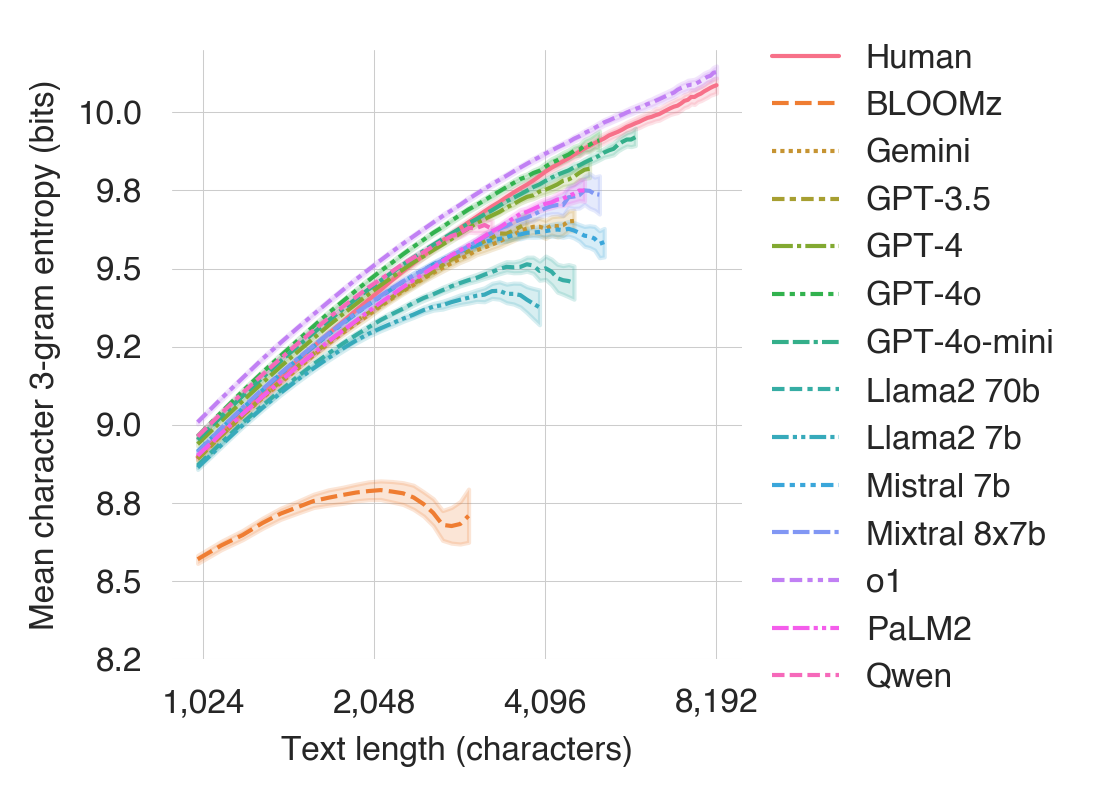

In [89]:
plot_entropy_per_model(entropy_pan_extended.query('not model.str.contains("(par)", regex=False)'),
                       xlim=(1000, 8200), ylim=(8.25, 10.2), ngram_order=3, savefig='../data/figures/entropy-pan-extended.pdf')

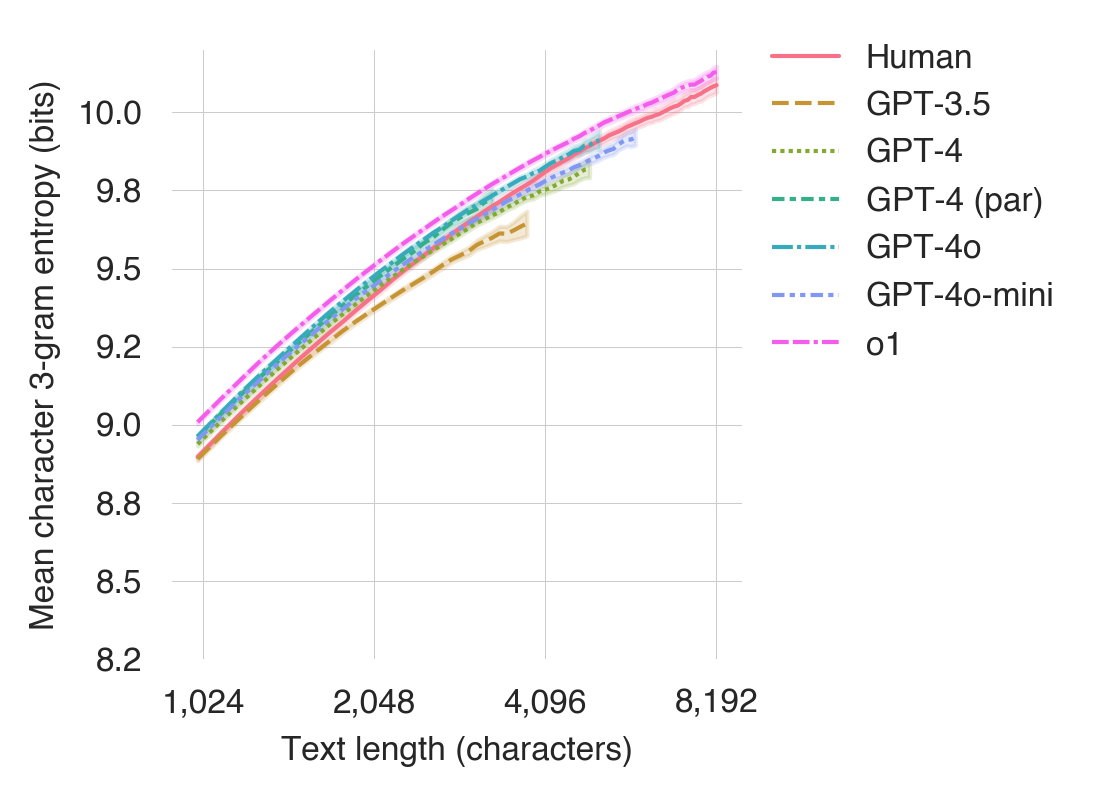

In [90]:
entropy_pan_extended_openai = entropy_pan_extended.query('model.str.startswith("GPT") or model.str.startswith("o1") or model.str.startswith("Human")')
plot_entropy_per_model(entropy_pan_extended_openai, xlim=(1000, 8200), ylim=(8.25, 10.2), ngram_order=3, savefig='../data/figures/entropy-pan-extended-gpt.pdf')

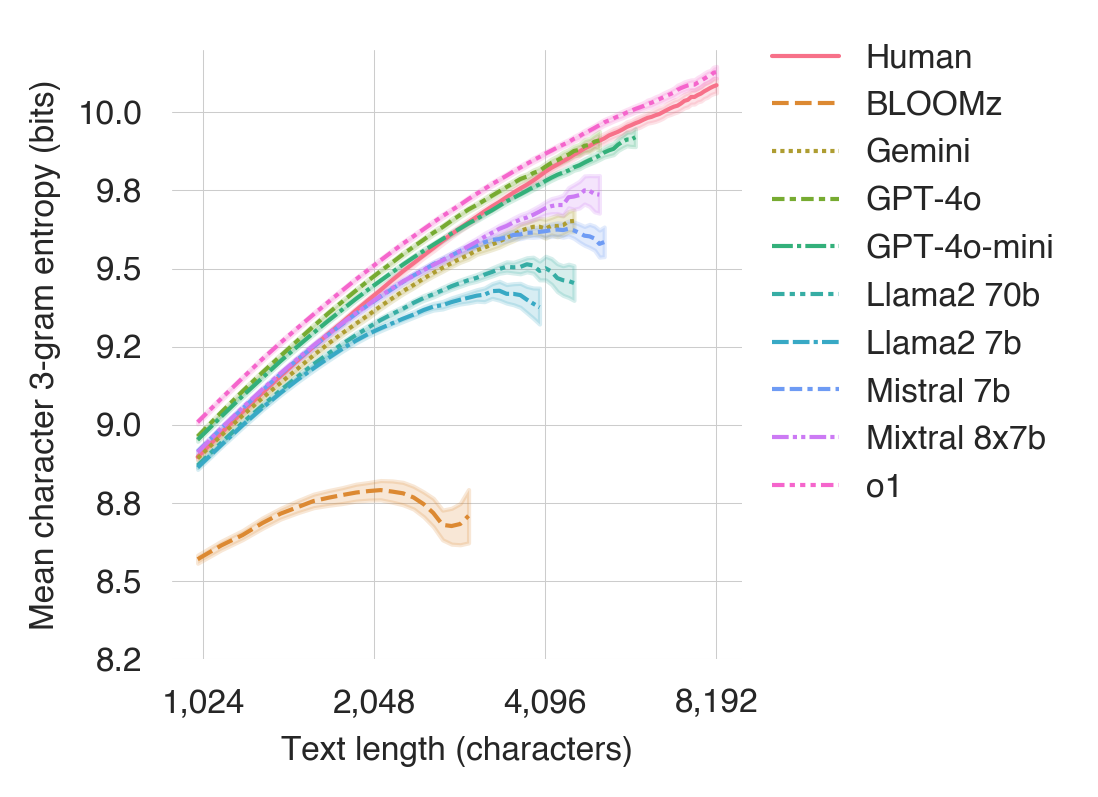

In [91]:
entropy_pan_extended_selected = entropy_pan_extended.query('model in ["Human", "BLOOMz", "o1", "Gemini", "GPT-4o", "GPT-4o-mini", "Llama2 7b", "Llama2 70b", "Mistral 7b", "Mixtral 8x7b"]')
plot_entropy_per_model(entropy_pan_extended_selected, xlim=(1000, 8200), ylim=(8.25, 10.2), ngram_order=3, savefig='../data/figures/entropy-pan-extended-selected.pdf')

In [92]:
entropy_pan_extended.query('length == 2000 and entropy < 8.7').dropna().join(df_pan_extended.query('model == "BLOOMz"').set_index('id'), rsuffix='r')[['text', 'entropy']]

text  \
length id                                                                                                      
2000   bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  Tom Brady's Super Bowl career has been charact...   
       bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  Hurricane Ida has caused widespread flooding i...   
       bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  The Vice President met with the Prime Minister...   
       bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  The President's Call to Action on Vaccination:...   
       bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  Hearings took place in Egypt on Tuesday in rel...   
...                                                                                                      ...   
       bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  The Colonial Pipeline cybersecurity attack spa...   
       bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  Egypt's government has warned the ship that it...   
       bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  Jacob Chansley, the notorious 'QAnon shaman' w...   
       bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  Tiger Woods is competing at the PNC Championsh...   
       bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  Donald Rumsfeld is dead, at the age of 88. Rum...   

                                                            entropy  
length id                                                            
2000   bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  8.371116  
       bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  8.301645  
       bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  8.601038  
       bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  8.471172  
       bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  8.565187  
...                                                             ...  
       bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  8.341057  
       bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  8.315431  
       bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  8.563587  
       bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  8.208688  
       bigscience-bloomz-7b1/news-2021-01-01-2021-12-3...  8.594958  

[162 rows x 2 columns]

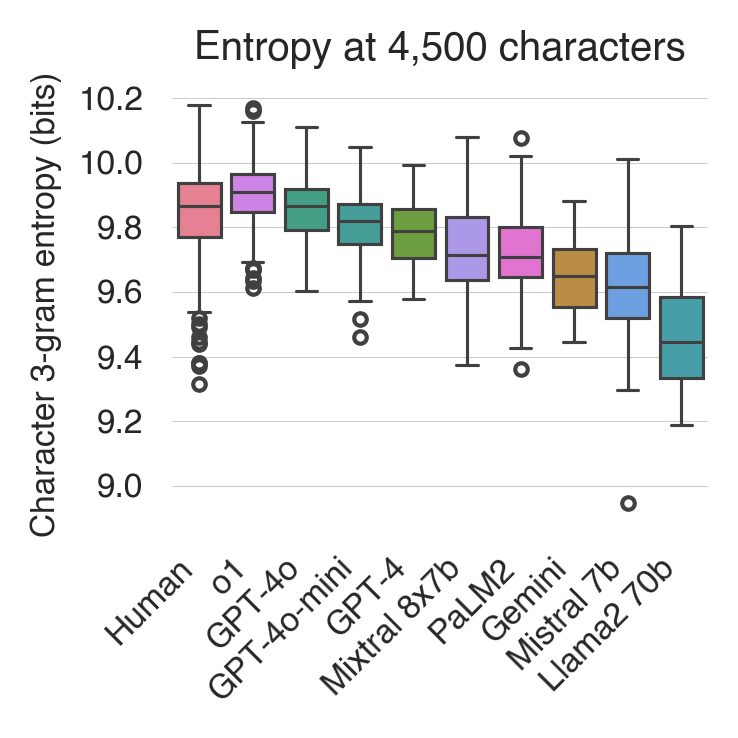

In [102]:
plot_entropy_box_plot_at_length(entropy_pan_extended, 4500, ngram_order=3, savefig='../data/figures/entropy-box-pan-extended.pdf')

### Kaggle Dataset
(King et al., 2023)

In [11]:
df_kaggle = load_data('../data/datasets/kaggle-converted')
entropy_kaggle = calc_at_length_intervals(partial(ngram_entropy, n=3), df_kaggle, 'entropy')

<LAMBDA> DONE:   0%|          | 0/23145 [00:00<?, ?it/s]

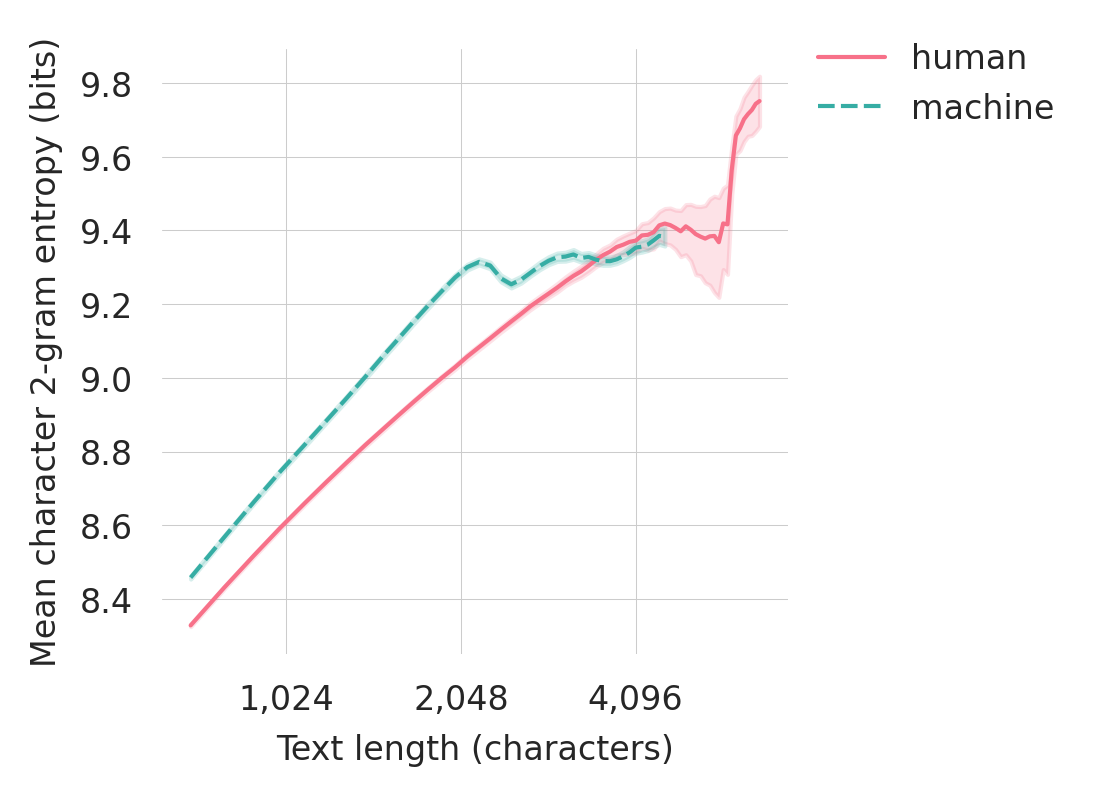

In [12]:
plot_entropy_per_model(entropy_kaggle, ngram_order=2)

### RAID Dataset
Dugan et al., 2024

In [10]:
model_map_raid = {
    'human': 'Human',
    'llama-chat': 'Llama2 70b (C)',
    'mistral': 'Mistral 7b',
    'mistral-chat': 'Mistral 7b (C)',
    'gpt3': 'GPT-3.5',
    'gpt4': 'GPT-4',
    'chatgpt': 'ChatGPT',
}

df_raid = load_data('../data/datasets/raid-good-models-no-attack-converted', model_map=model_map_raid)
entropy_raid = calc_at_length_intervals(partial(ngram_entropy, n=3), df_raid, 'entropy', max_length=4000)

<LAMBDA> DONE:   0%|          | 0/198059 [00:00<?, ?it/s]

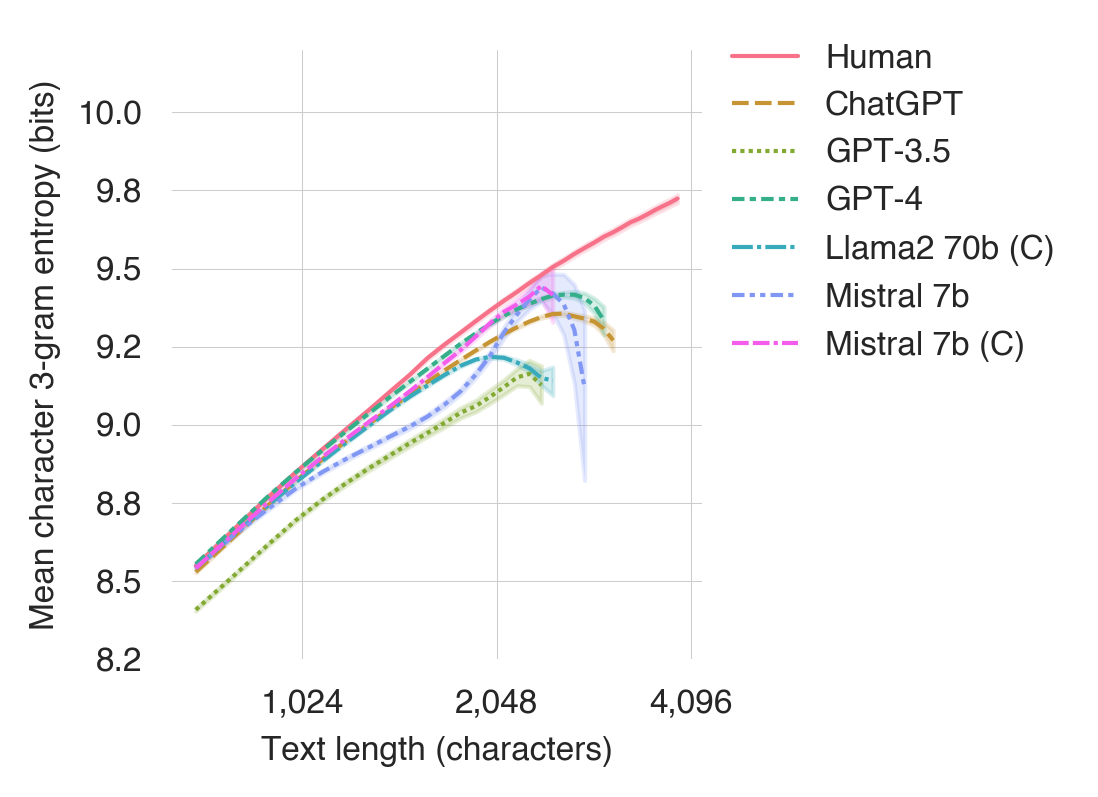

In [61]:
plot_entropy_per_model(entropy_raid, ngram_order=3, ylim=(8.25, 10.2), savefig='../data/figures/entropy-raid.pdf')

In [33]:
t = load_data('../data/datasets/raid-converted', split='train', filter_fn=lambda x: x['attack'] == 'none' and x['model'] == 'human' and len(x['text']) < 80)
t

Loading dataset from disk:   0%|          | 0/22 [00:00<?, ?it/s]

Filter (num_proc=24):   0%|          | 0/5044238 [00:00<?, ? examples/s]

,id,adv_source_id,source_id,label,decoding,repetition_penalty,attack,domain,title,prompt,text,model
0,6ae742ca-4767-4a7c-ad54-3e4b49fec624,6ae742ca-4767-4a7c-ad54-3e4b49fec624,6ae742ca-4767-4a7c-ad54-3e4b49fec624,0,None,None,none,reviews,Twilight,None,I think this movie suffered from lack of a goo...,human


In [81]:
t1 = load_data('../data/datasets/m4-converted', split='train', filter_fn=lambda x: len(x['text']) < 50)
t2 = load_data('../data/datasets/m4-converted', split='validation', filter_fn=lambda x: len(x['text']) < 50)
t3 = load_data('../data/datasets/m4-converted', split='test', filter_fn=lambda x: len(x['text']) < 50)
raid_short_texts = pd.concat([t1, t2, t3])
# print(raid_short_texts['model'].unique())
raid_short_texts[['model', 'text']]

Filter (num_proc=24):   0%|          | 0/114485 [00:00<?, ? examples/s]

Filter (num_proc=24):   0%|          | 0/800 [00:00<?, ? examples/s]

Filter (num_proc=24):   0%|          | 0/1000 [00:00<?, ? examples/s]

,model,text
0,human,iframe embed telah tercopy Embed Video
1,text-davinci-003,ead and good for the waistline too. Enjoy!
2,human,iframe embed telah tercopy Embed Video
3,human,iframe embed telah tercopy Embed Video
4,human,"A886 may refer to:\nOpteron\nA886 road, Scotland"
5,human,"REPUBLIKA.CO.ID,"
6,human,iframe embed telah tercopy Embed Video
7,human,iframe embed telah tercopy Embed Video
8,human,iframe embed telah tercopy Embed Video


In [16]:
# Degenerate text
entropy_raid.query('length == 2800 and entropy < 8.8').dropna().join(df_raid.set_index('id'), rsuffix='r').groupby('model').head(5)[['model', 'text', 'entropy']]

model  \
length id                                                      
2800   9c55b685-c12f-4164-b3b8-3726828c3c9b            Human   
       1f5bea19-ff40-43a5-8eb9-8a8d4a240d18       Mistral 7b   
       ca9c4000-3bd0-48d6-8982-2bff8277821f          ChatGPT   
       6c9a1365-8066-4371-8162-93ed91a6c7a5       Mistral 7b   
       a7f7ee97-074f-415f-a0a7-008f5be72804       Mistral 7b   
       501069a4-78d6-470c-b66d-e2141f1d4bb7       Mistral 7b   
       a1ecab29-8872-4a48-8eaf-e7e8e5db0d61          ChatGPT   
       f4fd1425-34d7-4067-8081-11a97f968209       Mistral 7b   
       2e8d5b68-fca2-411c-9525-5355d9dfec96          GPT-3.5   
       600e6a4d-6c5c-42e9-aade-580f2a8d3d91  Mistral 7b Chat   
       5a660532-32fb-4845-b5a2-824e20a155cc            Human   
       9459a49c-9108-4134-b5f2-a90142d50345            Human   
       16d57ef9-a274-4cba-8da4-66efea6ee6ad          ChatGPT   
       56682cf1-dcb4-407b-9966-1f1a340e329a            Human   
       a57bc549-412f-4fc7-a262-81dc8a4ffa17            Human   
       52143d23-9a1e-4903-84c0-3fe64e8eb303  Mistral 7b Chat   
       f8235d52-b056-4425-8620-899a2dd9f470          ChatGPT   

                                                                                          text  \
length id                                                                                        
2800   9c55b685-c12f-4164-b3b8-3726828c3c9b  Hope swirls around the little boy's head\nJump...   
       1f5bea19-ff40-43a5-8eb9-8a8d4a240d18  I'm not sure what to make of this film, but it...   
       ca9c4000-3bd0-48d6-8982-2bff8277821f  British intelligence agencies refer to the var...   
       6c9a1365-8066-4371-8162-93ed91a6c7a5  > We study the question of when a physical sys...   
       a7f7ee97-074f-415f-a0a7-008f5be72804  I'm not sure what to make of this film, but it...   
       501069a4-78d6-470c-b66d-e2141f1d4bb7  I am not sure if I should tell you this, but i...   
       a1ecab29-8872-4a48-8eaf-e7e8e5db0d61  Continuous-variable quantum information refers...   
       f4fd1425-34d7-4067-8081-11a97f968209  > Image segmentation is a fundamental problem ...   
       2e8d5b68-fca2-411c-9525-5355d9dfec96  \n\nAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   
       600e6a4d-6c5c-42e9-aade-580f2a8d3d91  AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   
       5a660532-32fb-4845-b5a2-824e20a155cc  A comet came with a large metal core\nRacing ‘...   
       9459a49c-9108-4134-b5f2-a90142d50345  Thanks a Lot, Mom\nThanks a lot, Mom.\nThanks ...   
       16d57ef9-a274-4cba-8da4-66efea6ee6ad  A cross-sectional regression is a statistical ...   
       56682cf1-dcb4-407b-9966-1f1a340e329a  Around the hub, the galaxies turn\nPinwheels s...   
       a57bc549-412f-4fc7-a262-81dc8a4ffa17  Money Money Money Money Money Money Money Mone...   
       52143d23-9a1e-4903-84c0-3fe64e8eb303  AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   
       f8235d52-b056-4425-8620-899a2dd9f470  Spatial-temporal reasoning is a cognitive abil...   

                                              entropy  
length id                                              
2800   9c55b685-c12f-4164-b3b8-3726828c3c9b  8.690476  
       1f5bea19-ff40-43a5-8eb9-8a8d4a240d18  8.593093  
       ca9c4000-3bd0-48d6-8982-2bff8277821f  8.739495  
       6c9a1365-8066-4371-8162-93ed91a6c7a5  5.868384  
       a7f7ee97-074f-415f-a0a7-008f5be72804  6.661009  
       501069a4-78d6-470c-b66d-e2141f1d4bb7  8.740712  
       a1ecab29-8872-4a48-8eaf-e7e8e5db0d61  8.659996  
       f4fd1425-34d7-4067-8081-11a97f968209  6.622807  
       2e8d5b68-fca2-411c-9525-5355d9dfec96  0.009215  
       600e6a4d-6c5c-42e9-aade-580f2a8d3d91 -0.000000  
       5a660532-32fb-4845-b5a2-824e20a155cc  4.941975  
       9459a49c-9108-4134-b5f2-a90142d50345  7.801641  
       16d57ef9-a274-4cba-8da4-66efea6ee6ad  8.763632  
       56682cf1-dcb4-407b-9966-1f1a340e329a  5.132274  
       a57bc549-412f-4fc7-a262-81dc8a4ffa17  3.022249  
       52143d23-9a1e-49

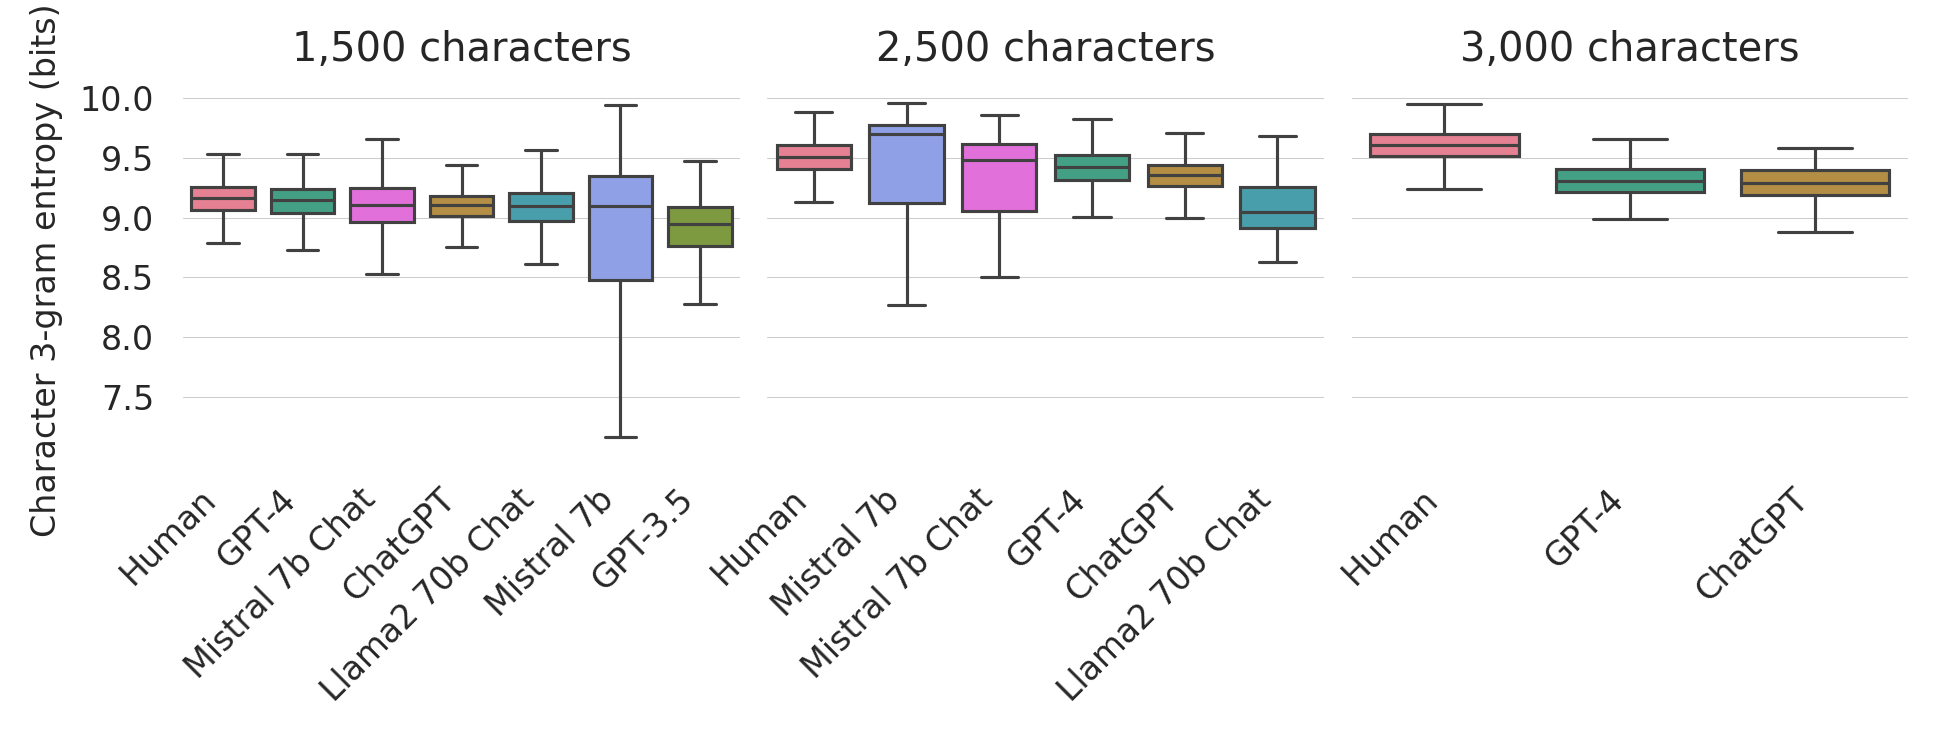

In [17]:
plot_entropy_box_plot_at_length(entropy_raid, [1500, 2500, 3000], ngram_order=3, showfliers=False)

#### RAID With Repetition Penalty

In [18]:
df_raid_rep_penalty = df_raid.query('repetition_penalty == "yes" or model == "Human"').query('not text.str.contains("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA")')
entropy_raid_rep_penalty = calc_at_length_intervals(partial(ngram_entropy, n=3), df_raid_rep_penalty, 'entropy', max_length=6000)

<LAMBDA> DONE:   0%|          | 0/74240 [00:00<?, ?it/s]

In [19]:
# Mistral generation loop despite repetition penalty
entropy_raid_rep_penalty.query('model == "Mistral 7b" and length == 2800 and entropy < 9.4').dropna().join(df_raid.set_index('id'), how='inner', rsuffix='r')['text']

length  id                                  
2800    1f5bea19-ff40-43a5-8eb9-8a8d4a240d18    I'm not sure what to make of this film, but it...
        a7f7ee97-074f-415f-a0a7-008f5be72804    I'm not sure what to make of this film, but it...
        501069a4-78d6-470c-b66d-e2141f1d4bb7    I am not sure if I should tell you this, but i...
        a4ce9db5-b337-493f-b1ee-8b840e0b8ae6    I'm not sure what to say about this film, othe...
        850261b8-a751-4ee1-a221-35a43ceafc09    > To my daughter, on her 16th birthday\n>\n> I...
        81b557de-8ce6-47e5-8c18-f42b3186b5ec    > I'm 23 years old and have been diagnosed wit...
        97f0ca60-bc78-46d6-bbc9-b6aa95b20daa    > How lonely do you feel?\n> I'm not talking a...
        a0a9a439-937a-4dca-9bb5-f66dc7dfc231    I'm not sure what to make of this film, but it...
        230d0654-52fe-4227-9028-4625482e280d    > Netflix has been in the news lately for thei...
        8d8f0321-721b-4ca2-a861-bec7bc7e883a    This film was made in 199

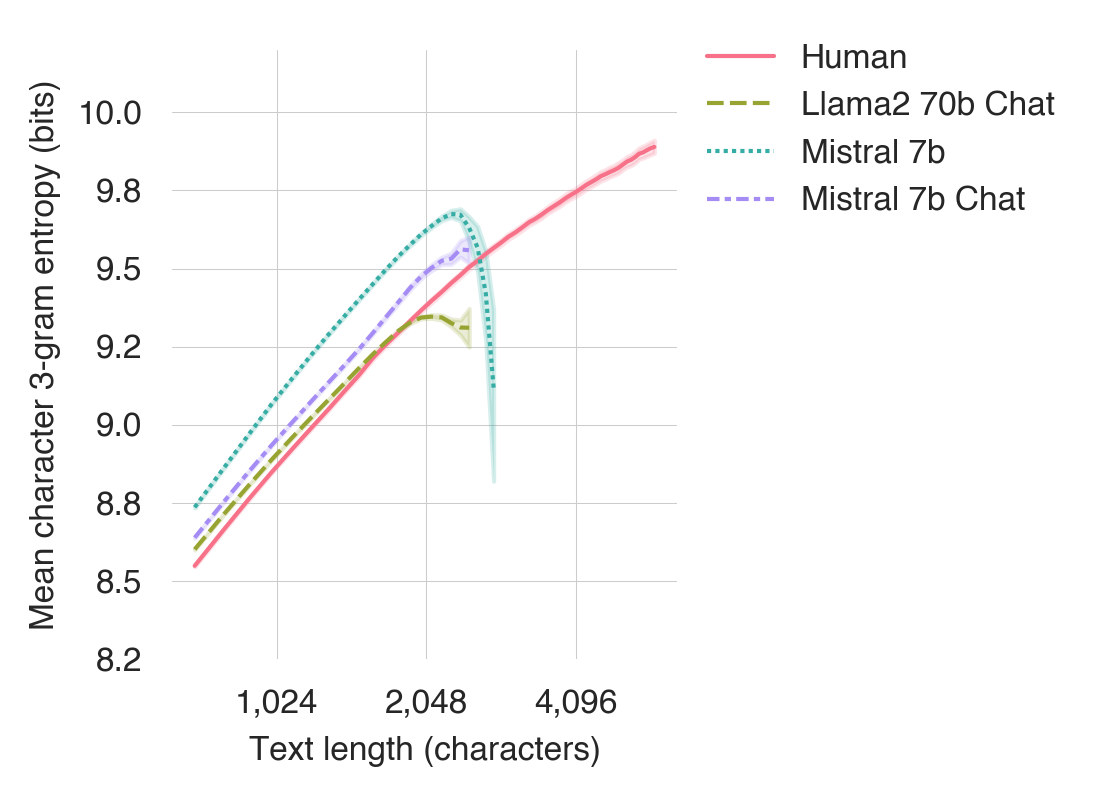

In [62]:
plot_entropy_per_model(entropy_raid_rep_penalty, ngram_order=3, ylim=(8.25, 10.2), savefig='../data/figures/entropy-raid-repetition-penalty.pdf')

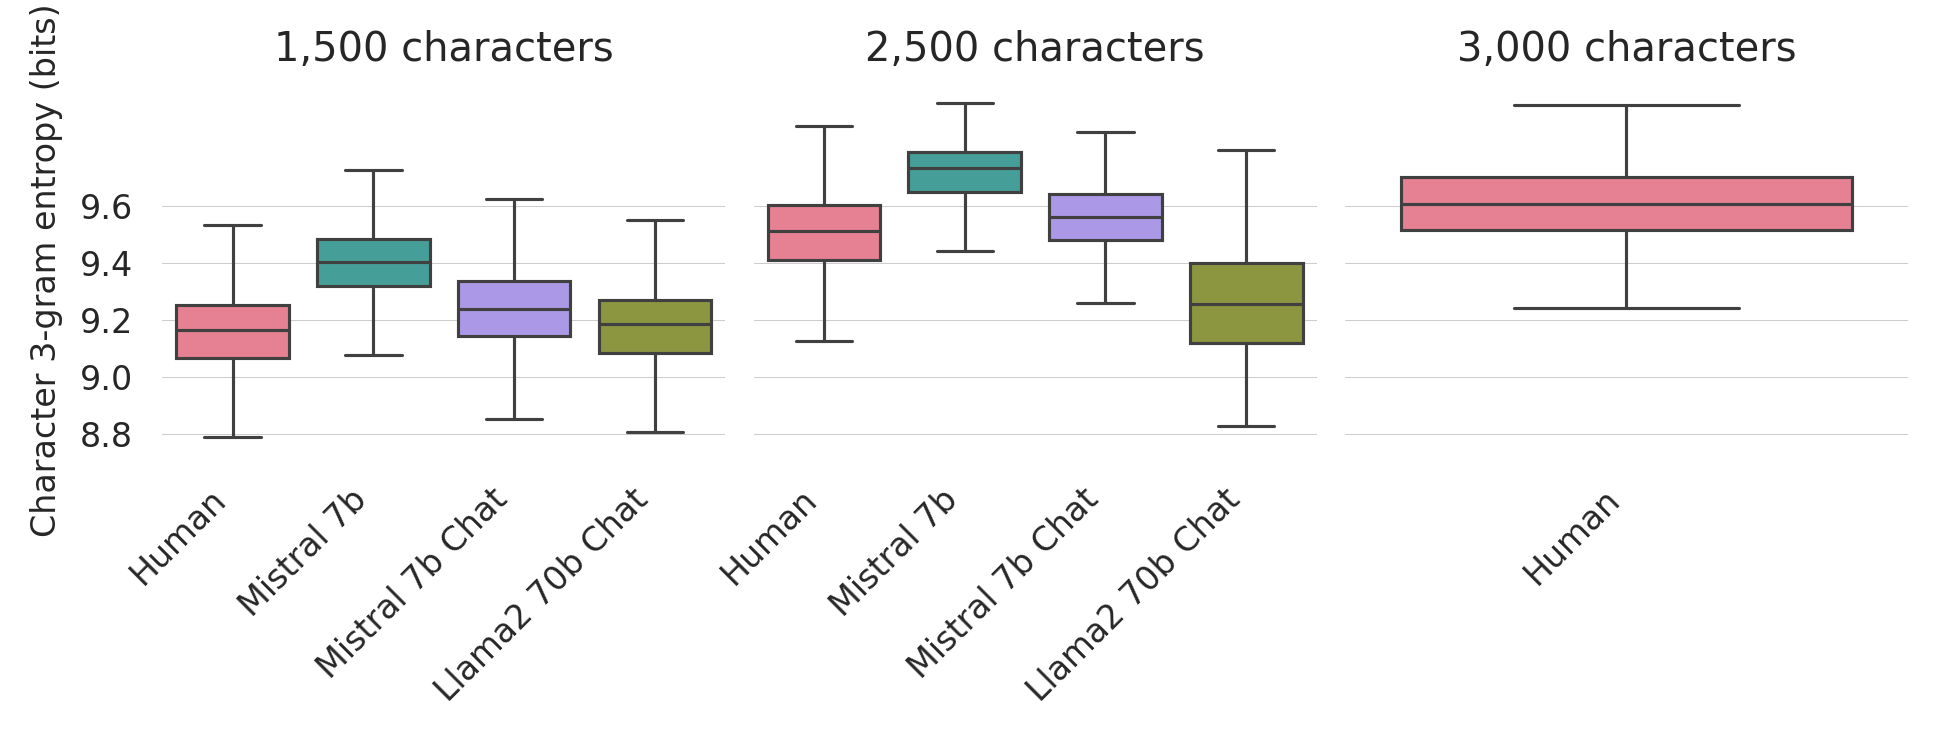

In [21]:
plot_entropy_box_plot_at_length(entropy_raid_rep_penalty, [1500, 2500, 3000], ngram_order=3, showfliers=False)

### Human Detectors Dataset
(Russell et al., 2025)

In [18]:
model_map_hd = {
    'human': 'Human',
    'claude' : 'Claude',
    'gpt-4o' : 'GPT-4o',
    'o1-pro' : 'o1',
    'humanized_o1-pro' : 'o1 (humanized)',
    'paraphrased_gpt-4o' : 'GPT-4o (paraph.)',
}
df_human_det = load_data('../data/datasets/human-detectors-converted', model_map=model_map_hd)
entropy_human_det = calc_at_length_intervals(partial(ngram_entropy, n=3), df_human_det, 'entropy')

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

<LAMBDA> DONE:   0%|          | 0/210 [00:00<?, ?it/s]

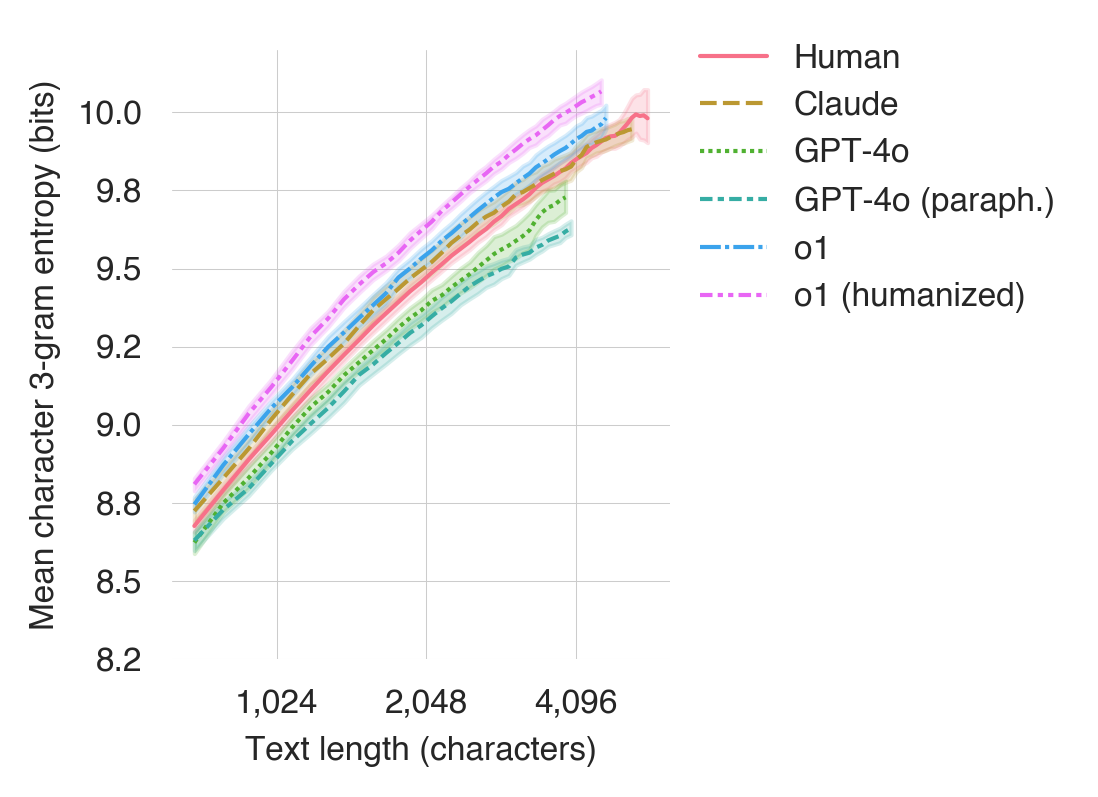

In [19]:
plot_entropy_per_model(entropy_human_det, ngram_order=3, min_samples=10, ylim=(8.25, 10.2), savefig='../data/figures/entropy-human-detectors.pdf')

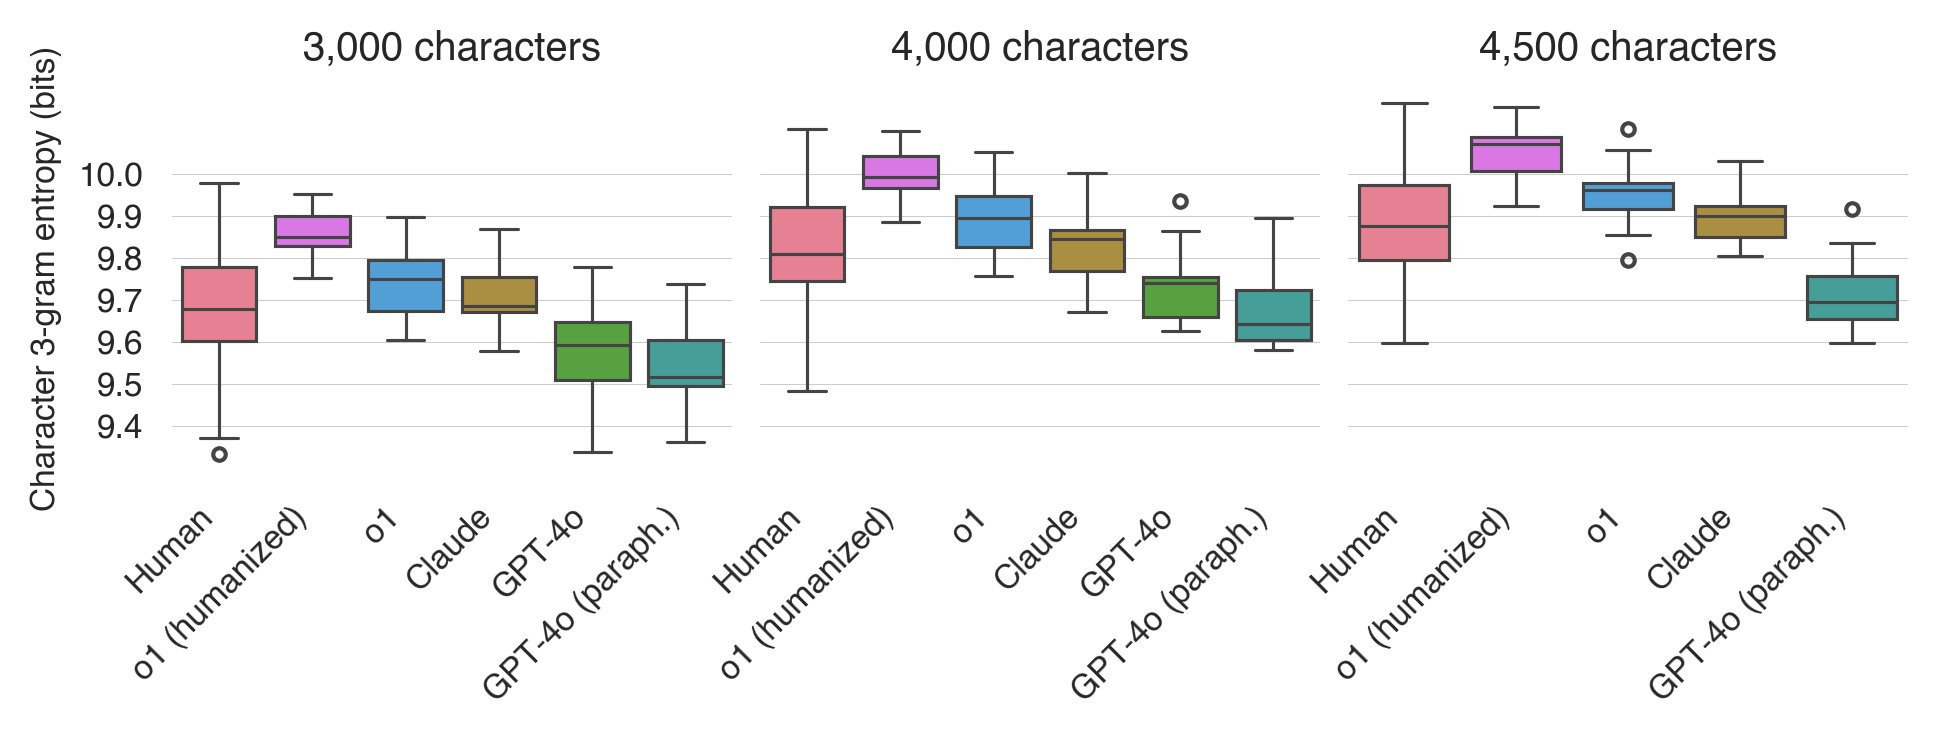

In [20]:
plot_entropy_box_plot_at_length(entropy_human_det, [3000, 4000, 4500], min_samples=10, ngram_order=3)

### Ghostbuster Dataset (Essay and Reuters)
(Verma et al., 2024)

In [25]:
df_ghostbuster_essay = load_data('../data/datasets/ghostbuster-essay-converted')
entropy_ghostbuster_essay = calc_at_length_intervals(partial(ngram_entropy, n=3), df_ghostbuster_essay, 'entropy', max_length=6000)

<LAMBDA> DONE:   0%|          | 0/5794 [00:00<?, ?it/s]

In [26]:
df_ghostbuster_reuters = load_data('../data/datasets/ghostbuster-reuters-converted')
entropy_ghostbuster_reuters = calc_at_length_intervals(partial(ngram_entropy, n=3), df_ghostbuster_reuters, 'entropy', max_length=6000)

<LAMBDA> DONE:   0%|          | 0/5800 [00:00<?, ?it/s]

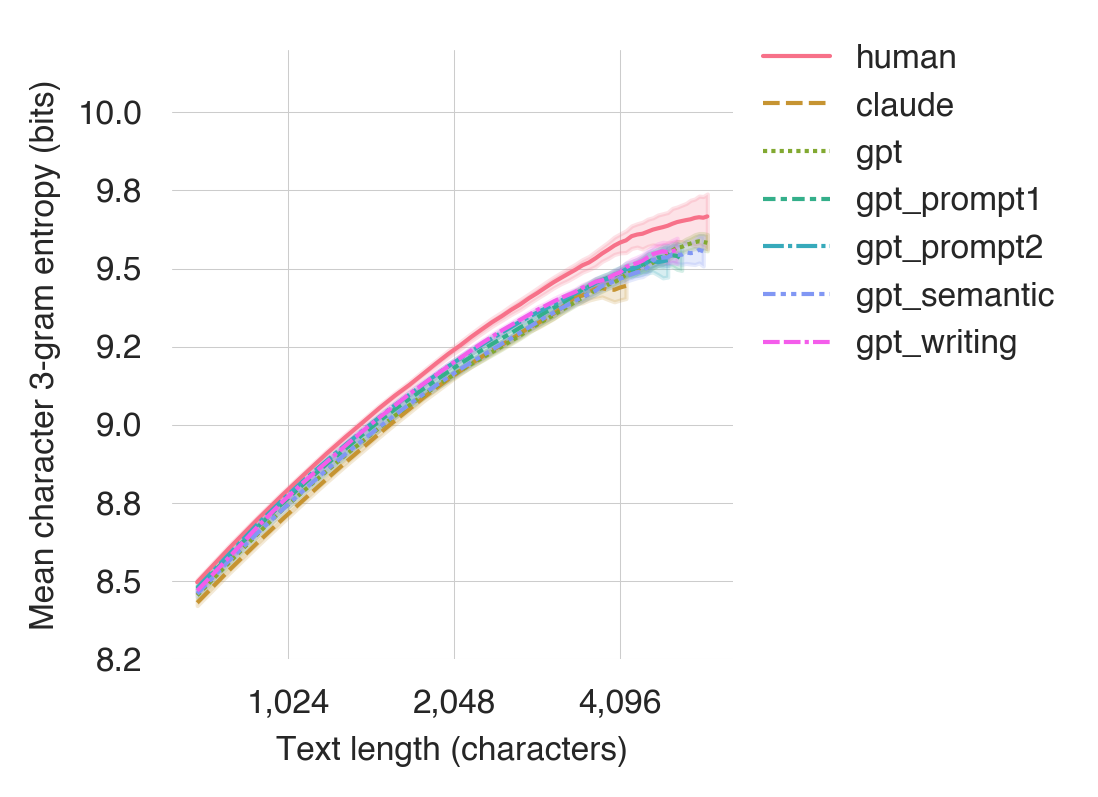

In [50]:
plot_entropy_per_model(entropy_ghostbuster_essay, ylim=(8.25, 10.2), ngram_order=3)

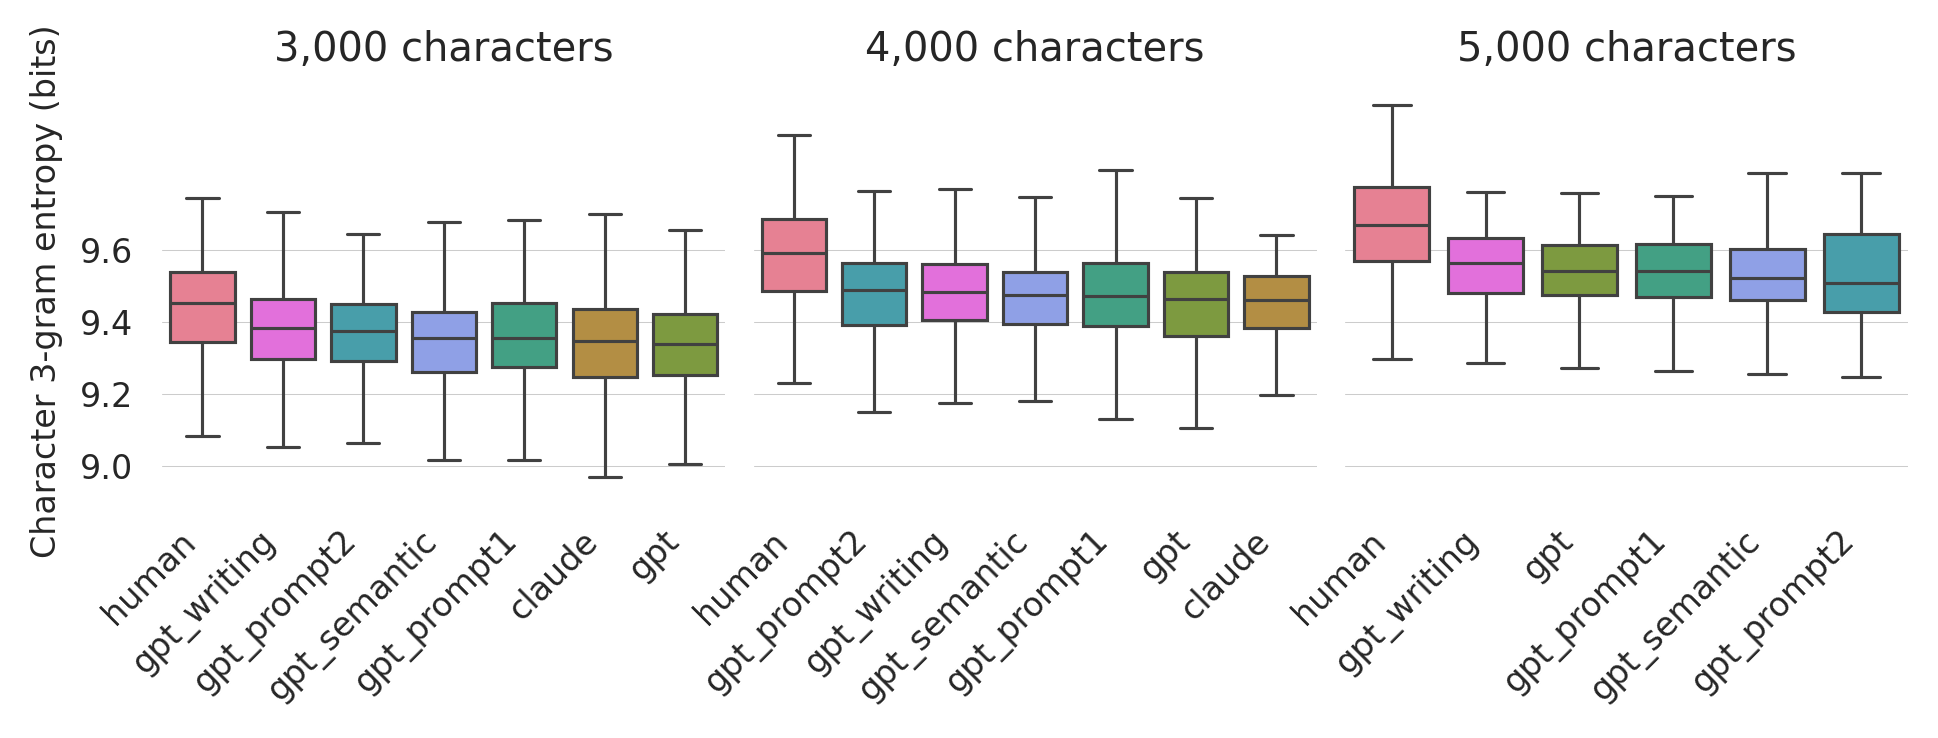

In [28]:
plot_entropy_box_plot_at_length(entropy_ghostbuster_essay, [3000, 4000, 5000], ngram_order=3, showfliers=False)

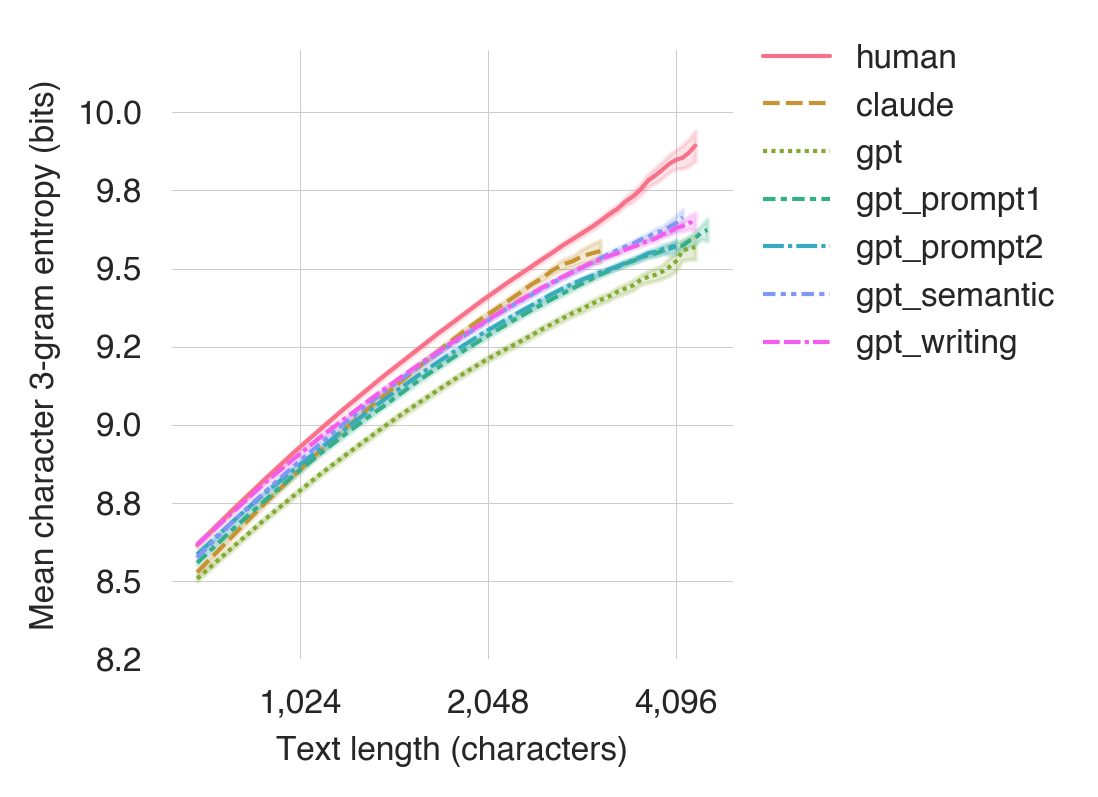

In [49]:
plot_entropy_per_model(entropy_ghostbuster_reuters, ylim=(8.25, 10.2), ngram_order=3)

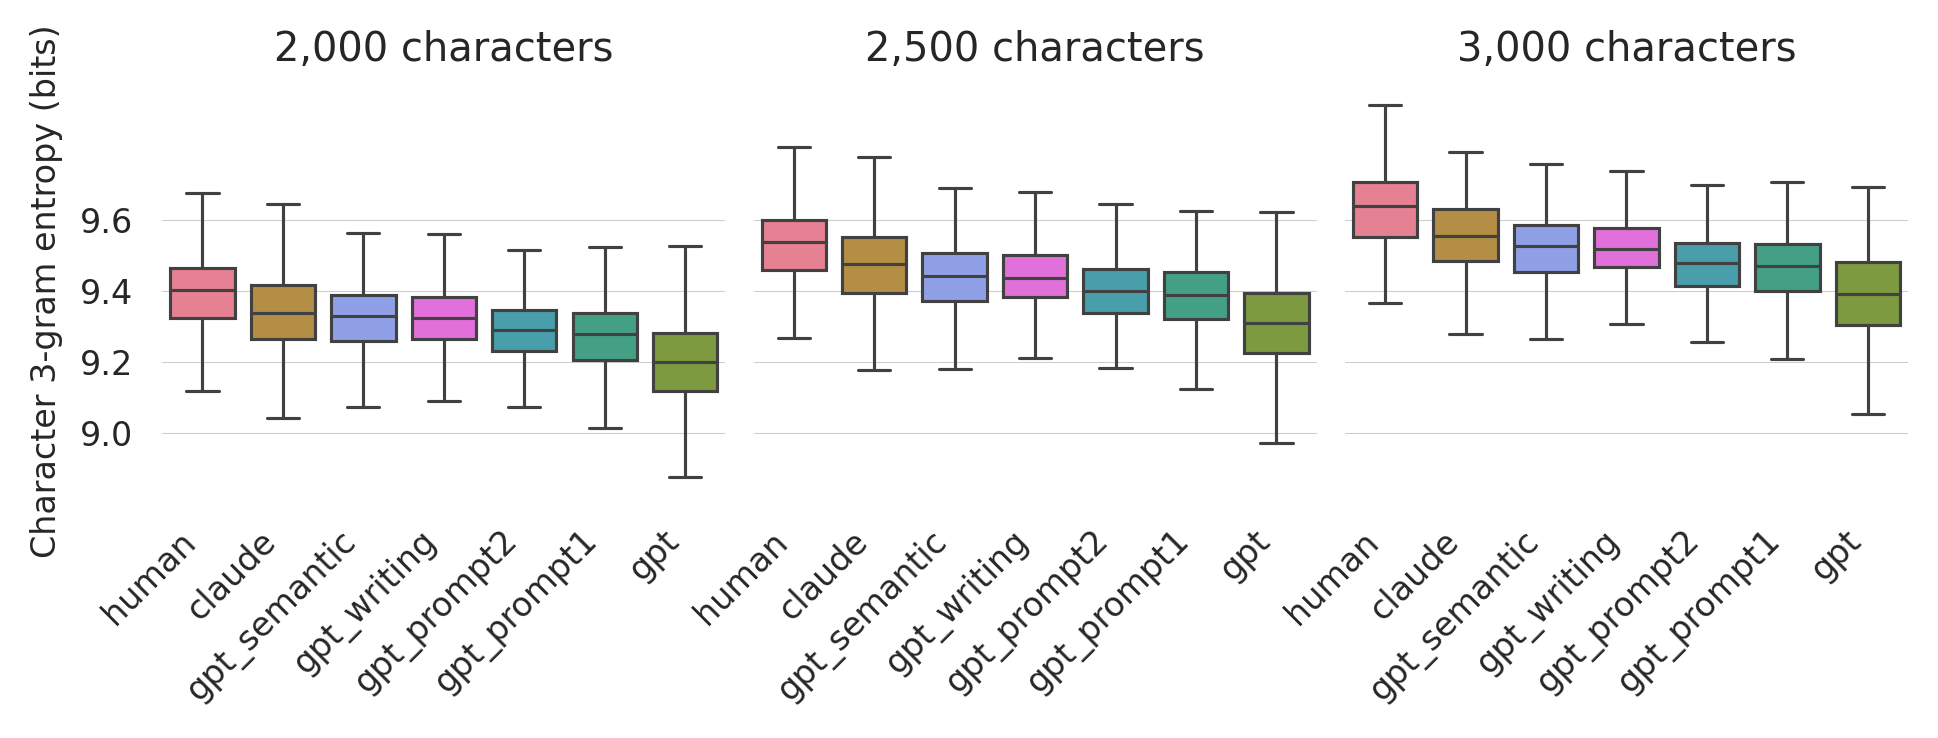

In [30]:
plot_entropy_box_plot_at_length(entropy_ghostbuster_reuters, [2000, 2500, 3000], ngram_order=3, showfliers=False)

### MAGE Dataset
(Li et al., 2024)

In [6]:
model_map_mage = {
    'human': 'Human',
    'gpt-3.5-trubo': 'GPT-3.5 Turbo',
    'text-davinci-002': 'GPT-3.5',
    'text-davinci-003': 'GPT-3.5',
    'gpt-j': 'GPT-J',
    'gpt-neox': 'GPT-NeoX',
}
df_mage = load_data('../data/datasets/mage-converted').query(
    'model.str.contains("human") or '
    'model.str.contains("text-davinci") or '
    'model.str.contains("gpt-3.5-trubo") or '  # sic!
    'model.str.contains("gpt_neox") or '
    'model.str.contains("gpt_j")')
df_mage['model'] = df_mage['model'].p_map(lambda x: model_map_mage[x.replace('gpt_', 'gpt-').split('_')[-1]])
entropy_mage = calc_at_length_intervals(partial(ngram_entropy, n=3), df_mage, 'entropy', max_length=6000)

MAP DONE:   0%|          | 0/115 [00:00<?, ?it/s]

<LAMBDA> DONE:   0%|          | 0/158242 [00:00<?, ?it/s]

In [7]:
df_mage.groupby('model').count()

,id,text,label,src
model,,,,
GPT-3.5,35185,35185,35185,35185
GPT-3.5 Turbo,18154,18154,18154,18154
GPT-J,6087,6087,6087,6087
GPT-NeoX,5498,5498,5498,5498
Human,93318,93318,93318,93318


In [8]:
entropy_mage.query('length == 4100 and entropy > 10.2').dropna().join(
    df_mage.set_index('id'), how='inner', rsuffix='r').sort_values('entropy', ascending=False).groupby('model').head(5)[['model', 'text', 'entropy']]

model  \
length id                                               
4100   7ebaba86-a663-47c5-a866-9d673b5c6bd0  GPT-NeoX   
       3ed0a49d-eedb-4759-ae0e-bb9fd59052b9     GPT-J   
       7915e1ed-b2b1-4ce0-bcf2-e359ad204682  GPT-NeoX   
       50b15401-8ab3-4c74-820f-d796c0642491  GPT-NeoX   
       50352cc8-dcbe-4354-8948-32db0eca05b3     GPT-J   
       5aaca269-9f6f-4f57-8771-96f56795f26c  GPT-NeoX   
       2581efd1-8fff-4246-9fc7-59ac9dbd0992  GPT-NeoX   
       5017c286-2b50-4f2b-994a-0abf371ad40c     GPT-J   
       e79e2159-4188-4f5b-b3f3-2f922ddd10ca     GPT-J   
       7fda585e-43cb-4553-a5ff-6b96737c0093     GPT-J   
       6853a627-6e63-4aed-b81e-a31fec32c199     Human   
       cef010c5-4347-4bae-b791-20a880689729     Human   

                                                                                          text  \
length id                                                                                        
4100   7ebaba86-a663-47c5-a866-9d673b5c6bd0  Sports programming is also provided on some we...   
       3ed0a49d-eedb-4759-ae0e-bb9fd59052b9  My glasses had skittered far away from me. Thr...   
       7915e1ed-b2b1-4ce0-bcf2-e359ad204682  In 1226, immediately after returning from the ...   
       50b15401-8ab3-4c74-820f-d796c0642491  By 1620 the Huguenots were on the defensive, a...   
       50352cc8-dcbe-4354-8948-32db0eca05b3  The newer part of the hotel is very swanky. Gr...   
       5aaca269-9f6f-4f57-8771-96f56795f26c  He was speaking after crowds in Tehran cheered...   
       2581efd1-8fff-4246-9fc7-59ac9dbd0992  In 1521 Luther dealt largely with prophecy, in...   
       5017c286-2b50-4f2b-994a-0abf371ad40c  A Laughably Poor Existence of an Amusement Par...   
       e79e2159-4188-4f5b-b3f3-2f922ddd10ca  I had a buy 1 get 1 coupon so my fiance and I ...   
       7fda585e-43cb-4553-a5ff-6b96737c0093  There should be nothing acceptable about walki...   
       6853a627-6e63-4aed-b81e-a31fec32c199  " You haven't actually told me what's going on...   
       cef010c5-4347-4bae-b791-20a880689729  What the bloody hell was my boss thinking? Thr...   

                                               entropy  
length id                                               
4100   7ebaba86-a663-47c5-a866-9d673b5c6bd0  10.749192  
       3ed0a49d-eedb-4759-ae0e-bb9fd59052b9  10.664493  
       7915e1ed-b2b1-4ce0-bcf2-e359ad204682  10.621110  
       50b15401-8ab3-4c74-820f-d796c0642491  10.583061  
       50352cc8-dcbe-4354-8948-32db0eca05b3  10.580745  
       5aaca269-9f6f-4f57-8771-96f56795f26c  10.579218  
       2581efd1-8fff-4246-9fc7-59ac9dbd0992  10.578017  
       5017c286-2b50-4f2b-994a-0abf371ad40c  10.534137  
       e79e2159-4188-4f5b-b3f3-2f922ddd10ca  10.533032  
       7fda585e-43cb-4553-a5ff-6b96737c0093  10.513796  
       6853a627-6e63-4aed-b81e-a31fec32c199  10.265269  
       cef010c5-4347-4bae-b791-20a880689729  10.224206

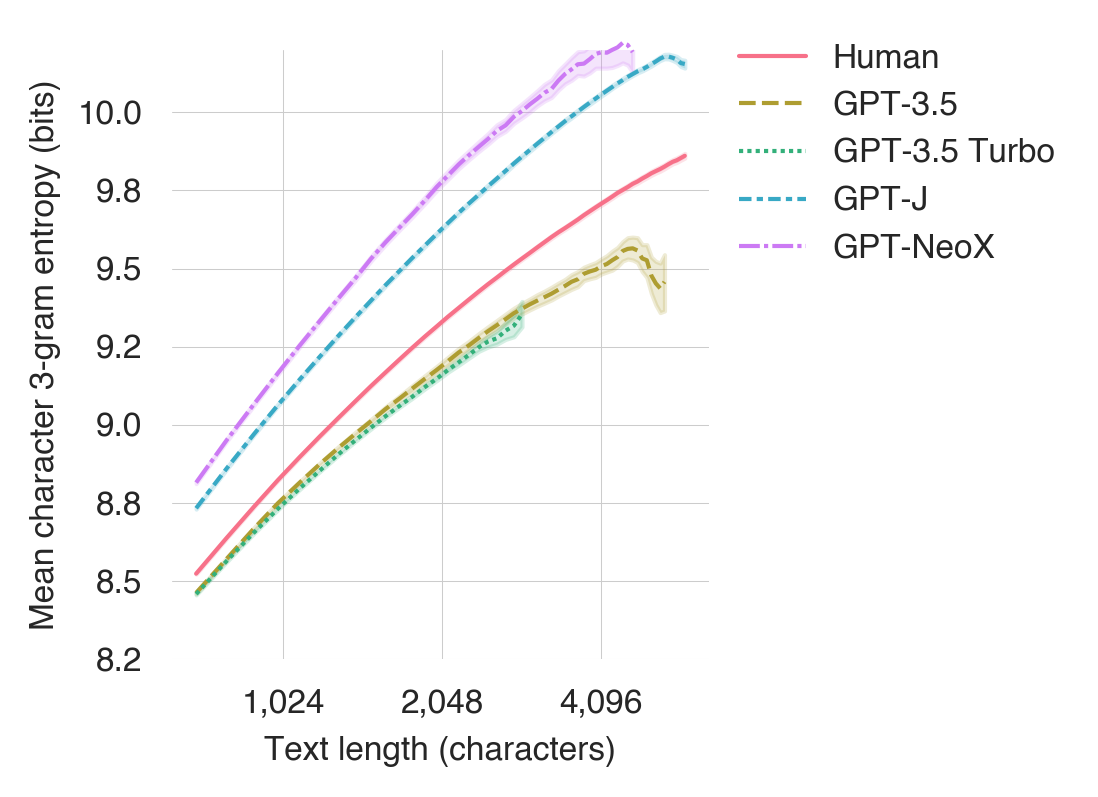

In [13]:
plot_entropy_per_model(entropy_mage, ngram_order=3, ylim=(8.25, 10.2), savefig='../data/figures/entropy-mage.pdf')

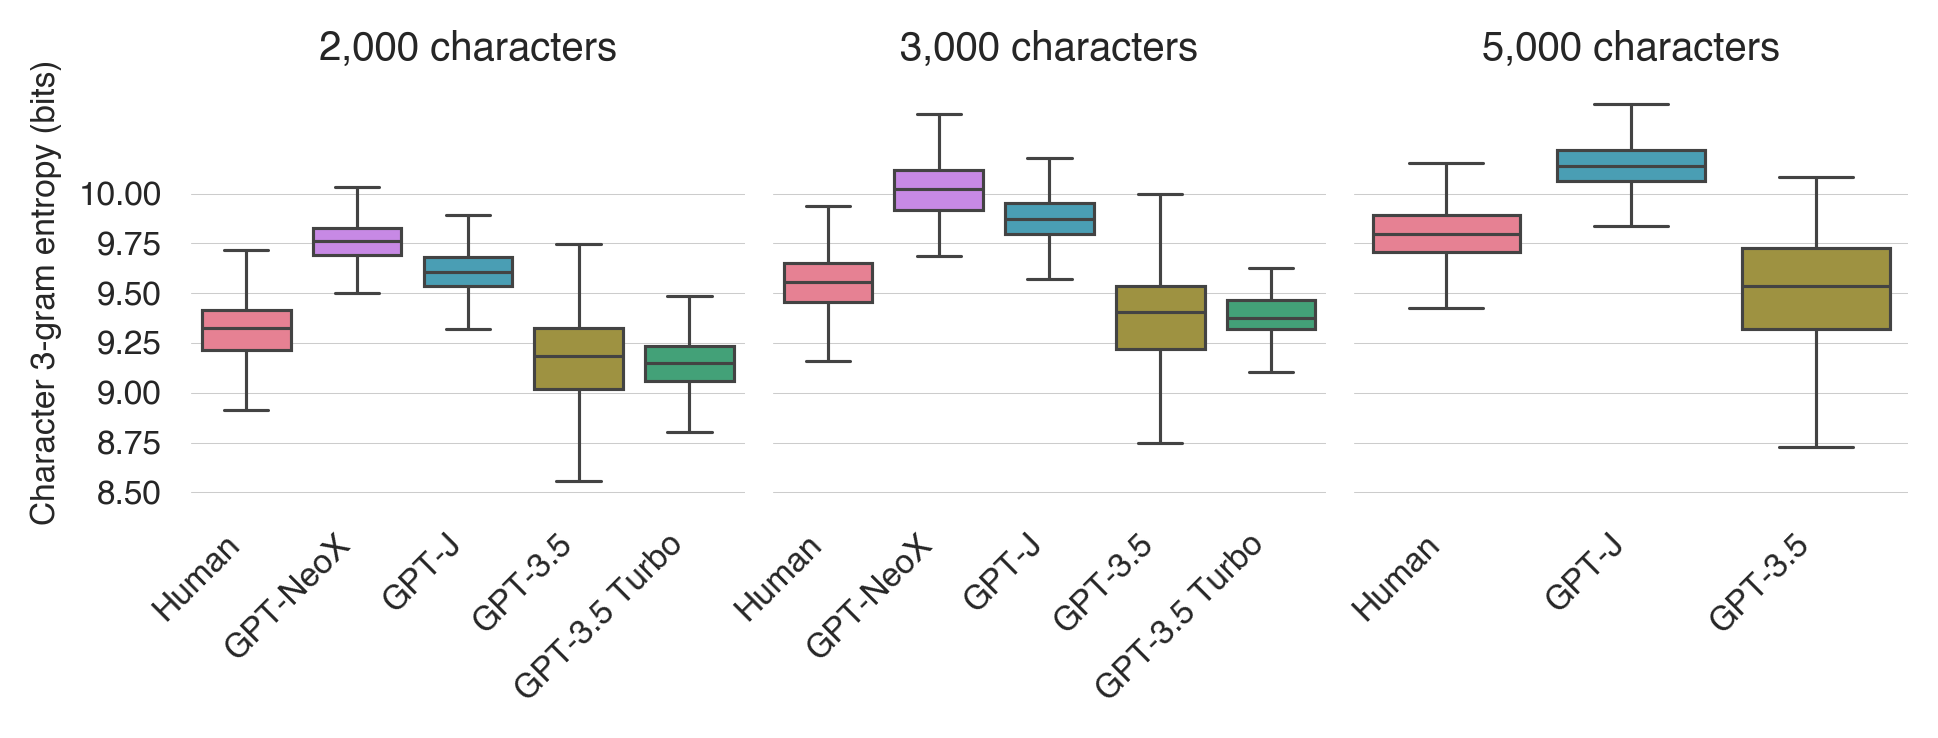

In [21]:
plot_entropy_box_plot_at_length(entropy_mage, [2000, 3000, 5000], ngram_order=3, showfliers=False)

### M4 Dataset (Wang et al., 2024)

In [5]:
model_map_m4 = {
    'human': 'Human',
    'bigscience/bloomz': 'BLOOMz',
    'chatgpt': 'ChatGPT',
    'davinci': 'DaVinci',
    'gpt-3.5-turbo': 'GPT-3.5',
    'text-davinci-003': 'GPT-3.5',
    'cohere': 'Cohere',
    'cohere-xlarge-nightly': 'Cohere',
    'command-xlarge-nightly': 'Cohere',
    'dolly-v2-12b': 'Dolly',
}
df_m4 = load_data('../data/datasets/m4-converted', model_map=model_map_m4)

def _strip_prompt(x):
    # Unfortunately, variables in the prompt are not expanded, so this is very approximate
    if x['prompt'] and x['text'].startswith(x['prompt'][:50]):
        p_end = x['prompt'].strip().split('\n')[-1] + '\n'
        x['text'] = x['text'].split(p_end, 1)[-1]
    return x

df_m4 = df_m4.p_apply(_strip_prompt, axis=1)
entropy_m4 = calc_at_length_intervals(partial(ngram_entropy, n=3), df_m4, 'entropy', max_length=6000)

_STRIP_PROMPT DONE:   0%|          | 0/114485 [00:00<?, ?it/s]

<LAMBDA> DONE:   0%|          | 0/114485 [00:00<?, ?it/s]

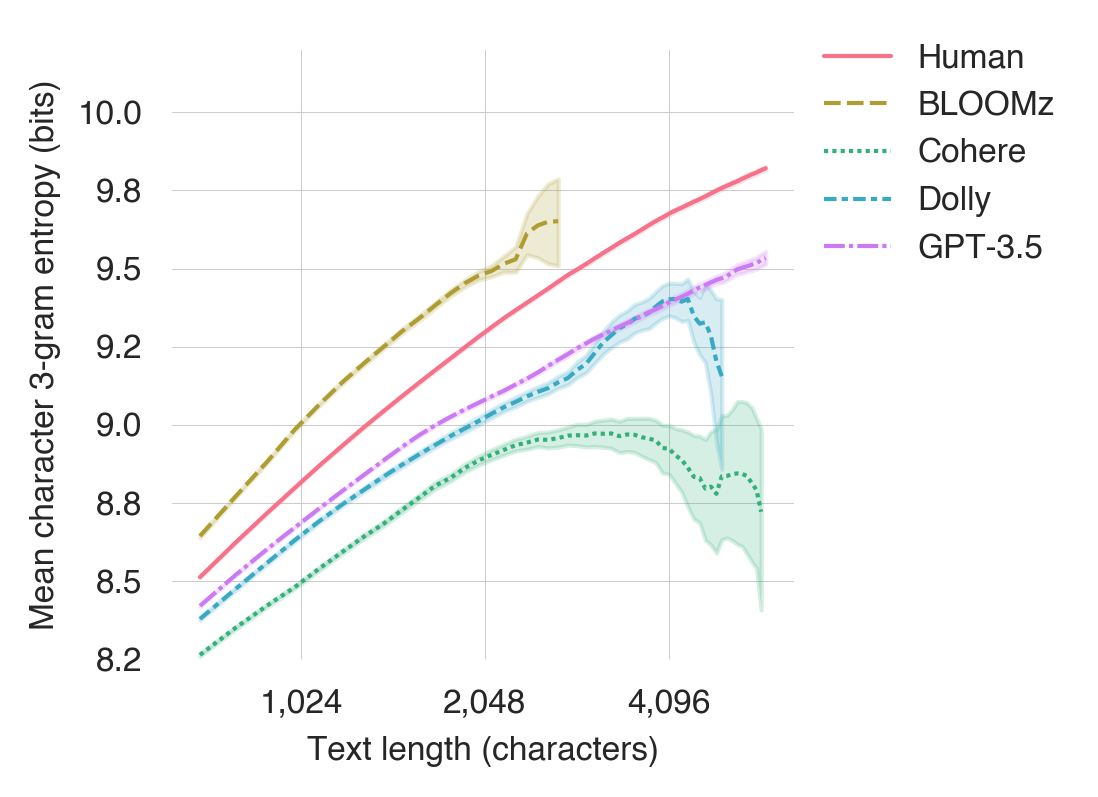

In [64]:
plot_entropy_per_model(entropy_m4, ngram_order=3, ylim=(8.25, 10.2), savefig='../data/figures/entropy-m4.pdf')

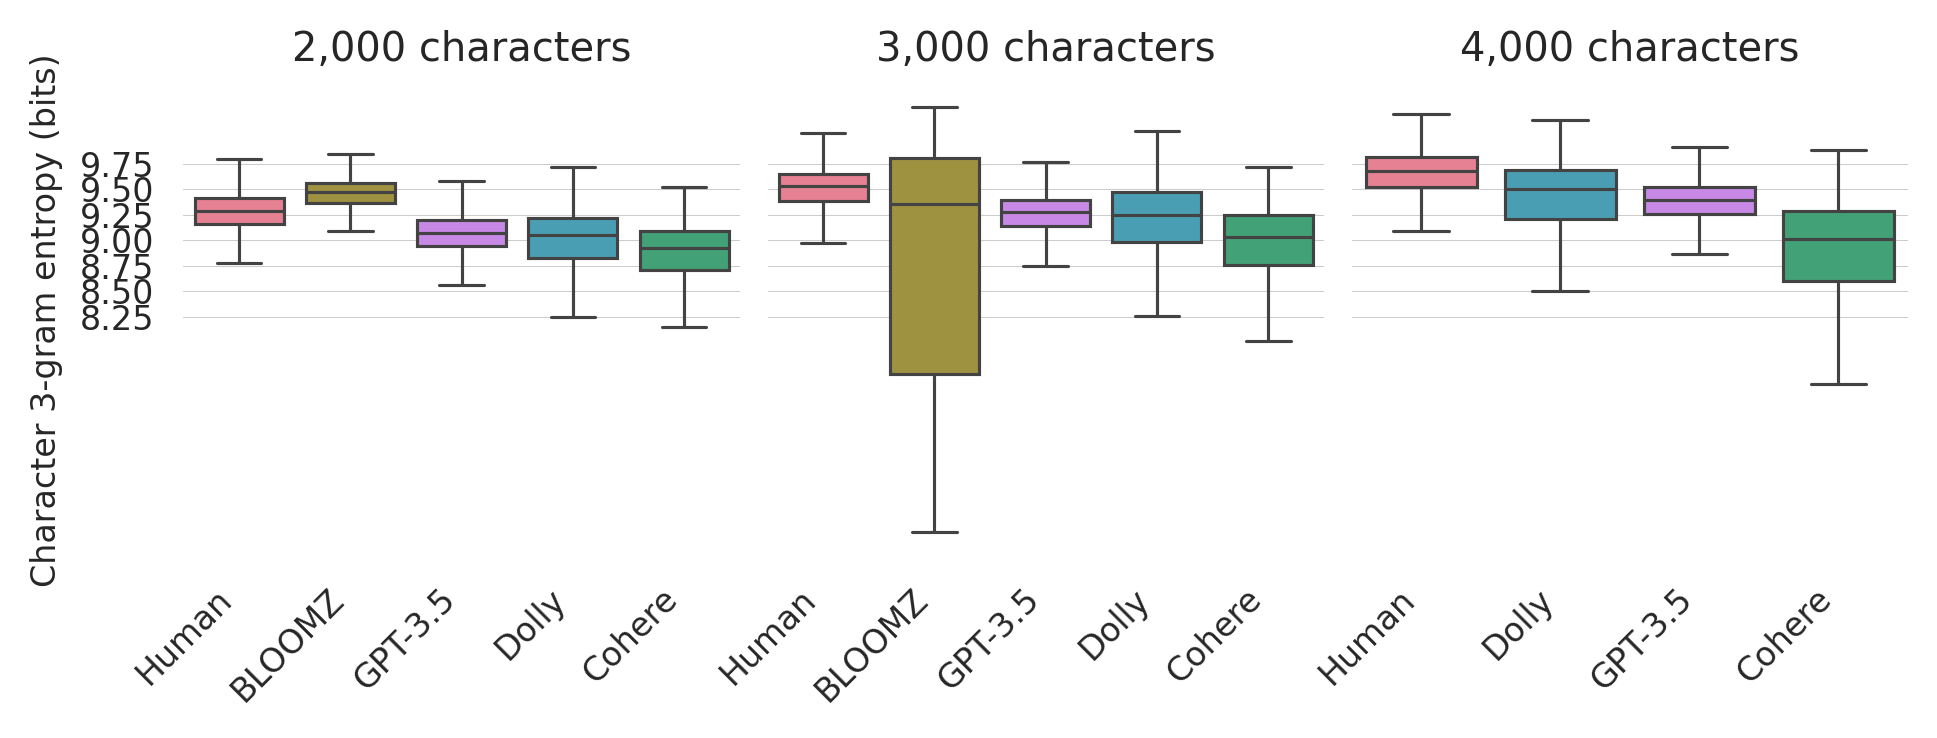

In [38]:
plot_entropy_box_plot_at_length(entropy_m4, [2000, 3000, 4000], ngram_order=3, showfliers=False)

In [9]:
entropy_m4.query('length == 2400 and entropy > 9.3').dropna().join(df_m4.set_index('id').query('model == "BLOOMz"'), how='inner', rsuffix='r')[['text', 'entropy']]

text  \
length id                                                                                        
2400   f865e0e7-d037-4ac0-9199-005562067546  If you'd like to learn how to draw this charac...   
       14800025-500d-4f1b-8be9-8d590b422b5d  Rotational grazing involves moving livestock a...   
       70f0b7f1-6593-48ec-ba55-18d9b2c686a2  We present here an overview of our numerical m...   
       c7a7cef3-f099-4040-b0aa-1fb8ea8f658c  We present an orbital-free density functional ...   
       aa8959d3-a016-4f9f-952e-c2c07cdff6f2  Creating an Account Sign up at wildfire.com if...   
...                                                                                        ...   
       60bd941f-715d-4bd6-8e2d-e6f6651a25db  We report on the observation of extremely slow...   
       e5fa1ed5-90a9-4134-9bf9-691e5c467290  If you're reading this page now it's probably ...   
       096f8b49-3ad4-4143-88f9-d167803a3457  As young adults we are faced with many challen...   
       590b96c7-6c0f-40d8-8ca2-70dd7c2c2608  We present an algorithm that efficiently creat...   
       cebd273d-6652-4d89-b040-0b227c24914c  Aspirin is one of the most common over-the-cou...   

                                              entropy  
length id                                              
2400   f865e0e7-d037-4ac0-9199-005562067546  9.862250  
       14800025-500d-4f1b-8be9-8d590b422b5d  9.506558  
       70f0b7f1-6593-48ec-ba55-18d9b2c686a2  9.459437  
       c7a7cef3-f099-4040-b0aa-1fb8ea8f658c  9.612357  
       aa8959d3-a016-4f9f-952e-c2c07cdff6f2  9.588101  
...                                               ...  
       60bd941f-715d-4bd6-8e2d-e6f6651a25db  9.559162  
       e5fa1ed5-90a9-4134-9bf9-691e5c467290  9.848187  
       096f8b49-3ad4-4143-88f9-d167803a3457  9.494635  
       590b96c7-6c0f-40d8-8ca2-70dd7c2c2608  9.514636  
       cebd273d-6652-4d89-b040-0b227c24914c  9.797615  

[78 rows x 2 columns]

### Human Entropy Means

In [40]:
entropy = {
    'PAN\'24': entropy_pan_extended,
    'HD': entropy_human_det,
    'RAID': entropy_raid,
    'GB (Reuters)': entropy_ghostbuster_reuters,
    'GB (Essays)': entropy_ghostbuster_essay,
    'MAGE': entropy_mage,
    'M4': entropy_m4,
}
means = []
for l in tqdm([1000, 2000, 4000]):
    for k, d in entropy.items():
        m = d.query('model.str.lower() == "human" and length == @l')['entropy'].dropna()
        if len(m) < 30:
            continue
        b = stats.bootstrap([m], np.mean, confidence_level=.9, vectorized=True, rng=42)
        mu = np.mean(b.bootstrap_distribution)
        lo, hi = b.confidence_interval
        means.append({'length': l, 'dataset': k, 'mu': mu, 'lo': lo, 'hi': hi})

means = pd.DataFrame.from_dict(means).set_index(['length', 'dataset'])
means

  0%|          | 0/3 [00:00<?, ?it/s]

mu        lo        hi
length dataset                                   
1000   PAN'24        8.888525  8.880839  8.895203
       HD            8.960552  8.941101  8.978191
       RAID          8.826722  8.822066  8.830429
       GB (Reuters)  8.907854  8.901750  8.914088
       GB (Essays)   8.759537  8.744070  8.769769
       MAGE          8.814643  8.813215  8.816059
       M4            8.787720  8.786448  8.788930
2000   PAN'24        9.394468  9.387380  9.401571
       HD            9.450730  9.429850  9.469377
       RAID          9.352570  9.341522  9.360283
       GB (Reuters)  9.393017  9.386258  9.399681
       GB (Essays)   9.216810  9.204102  9.227145
       MAGE          9.309386  9.307034  9.311796
       M4            9.271033  9.268913  9.273284
4000   PAN'24        9.791851  9.782069  9.801951
       HD            9.827470  9.802840  9.853495
       GB (Reuters)  9.835402  9.810880  9.859824
       GB (Essays)   9.569121  9.536506  9.588298
       MAGE          9.692788  9.688722  9.696877
       M4            9.655241  9.651795  9.658681

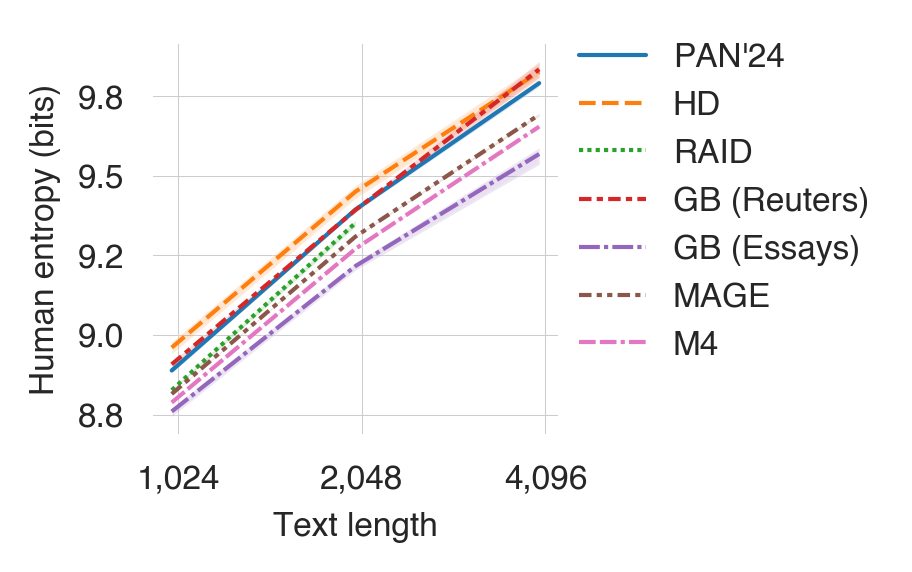

In [70]:
plt.figure(figsize=(3, 1.9))
ax = sns.lineplot(means, x='length', y='mu', hue='dataset', style='dataset')

lengths = means.index.get_level_values(0).unique()
for d in means.index.get_level_values(1).unique():
    ax.fill_between(means.swaplevel().loc[d].index, means.swaplevel().loc[d]['lo'], means.swaplevel().loc[d]['hi'], alpha=.2)

ax.legend(title=None, frameon=False, bbox_to_anchor=(.98, 1.08), loc='upper left')
ax.set_ylabel('Human entropy (bits)')
ax.set_xlabel('Text length')
ax.set_xscale('log', base=2)
ax.set_xticks([2**int(np.ceil(np.log2(l))) for l in lengths])
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.1f}'))
sns.despine(ax=ax, trim=True, left=True, bottom=True)
plt.tight_layout(pad=.8)
plt.savefig('../data/figures/entropy-mean-human.pdf', bbox_inches='tight', pad_inches=0)
plt.show()